##  Mise en oeuvre des méthodes d'apprentissage non supervié  (*Implémentation d'un auto-encodeurs variationnels*) ##

Dans ce TP, nous allons mettre en oeuvre l'ensemble de la démarche classique en deep learning pour implémenter un auto-encodeur variationnel (VAE). Pour cela nous allons suivre des étapes qui vont du traitement des données, l'entrainement du modèle et le calcul de ses performance à travers des métriques qualitatives et quantitatives. Pour cela, dès lords qu'ils est écrit "# CODE HERE", il vous est demandé de remplir les cellules avec votre propre code.
Avant de demander de l'aide, reférez-vous à la documentation de la fonction ou de la librairies que vous souhaitez manipuler. C'est le secret de tout développeur !

**Jeu de données initial** : Un ensemble d'images représentant le jeu de données Dsprites. Il est composé de N = 737280 images.
Ces images ont été procédurallement générées à partir des six facteurs de génération indépendants suivant :
* idx_facteur 0 : **Couleur**: blanc
* idx_facteur 1 : **Forme** : carré, ellipse, coeur
* idx_facteur 2 : **Echelle**: 6 valeurs linéairement espacée dans [0.5, 1]
* idx_facteur 3 : **Orientation**: 40 valeurs dans [0, 2 pi]
* idx_facteur 4 : **Position sur X**: 32 valeurs dans [0, 1]
* idx_facteur 5 : **Position sur Y**: 32 valeurs in [0, 1]

**Objectif** : Le but de ce TP est d'entraîner un auto-encodeur variationnel capable de créer de nouvelles instances du jeu de donné d'apprentissage, tout en vérifiant sa capacité de désentrelacement à l'aide d'un latent traversal.


# I - Chargement et description du jeu de données#

Dans cette partie nous allons récupérer et traiter le jeu de données afin de pouvoir l'utiliser pour l'entraînement. Il est nécessaire dans un premier temps de le télécharger en local avant de l'importer sur le Google Collab.


## 1 - Chargement des données et affichage d'un batch aléatoire

**Importez le jeu de données dans un tableau numpy.**

Téléchargez le fichier "*dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz*" via le github suivant:
[Dsprites deep mind](https://github.com/google-deepmind/dsprites-dataset/blob/master/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz)

 Une fois en local sur votre ordinateur, chargez l'ensemble des données grâce à la fonction load() de la librairie.


In [137]:
# importer la librairie numpy que l'on nommera "np"

import numpy as np

# Utiliser la fonction load() de numpy afin de charger les données dans une
# variable que vous nommerez "dataset_zip".

## CODE HERE

dataset_zip = np.load("dsprites.npz")


Vérifiez le type de la variable dans laquelle vous avez chargé vos données. Y a t-il seulement des images ? Si non, affichez le nom des différents objets que contient votre variable.

In [138]:
# Afficher le type de la variable "dataset_zip"

print(type(dataset_zip))

<class 'numpy.lib.npyio.NpzFile'>


In [139]:
# Affichez le nom des différents objets contenus dans votre variable.

print(dataset_zip.files)

['metadata', 'imgs', 'latents_classes', 'latents_values']


Afin de pouvoir entraîner correctement le modèle avec les ressources (de calcul et de temps) à disposition, le jeu de données dois être considérablement réduit. Pour cela, nous n'allons considérer les images composées uniquement de trois facteurs génératifs: la couleur, l'échelle, la position sur x et la position sur y. De ce fait, nous souhaitons "fixer" le facteur d'orientation, et uniquement considérer les formes ovales.

Pour cela, nous allons dans un premier temps récupérer l'index des images pour lesquelles le facteur d'orientation est à 0, et la facteur de forme à 1.

***Indices : ***


1.   Comment récupérer la liste composée des valeurs des variables latentes ?  
2.   Si l'on considère un unique élément de cette liste, quel sont les deux index sur lesquels vérifier que la condition soit remplie (i.e orientation = 0 et forme = 1) ?
3. Comment récupérer l'index des données satisfaisant une condition dans une liste, en python ?


In [140]:
# Dans une variable "idx_ovalnoor" récupérer l'ensemble des indexs des images qui nous intéressent.

idx_ovalnoor = [i for i, j in enumerate(dataset_zip["latents_classes"]) if (j[3] == 0) and (j[1]==1)]

**Récupérez l'ensemble des images pour lesquelles l'orientation et la forme sont fixés**

Le jeu de données récupéré depuis la source github contient énormément d'informations sur les images, comme la valeur de chaque facteur génératif pour l'image considérée par exemple. Pour cette partie du TP, nous allons considérer uniquement les images.

In [141]:
# récupérer l'ensemble des images dans une variables "imgs", à partir de "dataset_zip".
# Nous souhaitons conserver uniquement les images pour lesquelles le facteur orientation est à 0 et la forme à 1
# c.a.d celles pour lesquelles l'index correspond à ceux récupérés dans la liste idx_ovalnoor.

imgs = dataset_zip['imgs'][idx_ovalnoor]

Dans la variable "imgs", les données sont ordonnées selon les facteurs génératifs. Ainsi, il est possible que les 1000
premières images représentent toutes des ellipses, etc... Afin de ne pas biaiser l'apprentissage du modèle, il est nécessaire de randomiser l'ordre des images.

In [142]:
# Mélanger l'ordre des données

np.random.shuffle(imgs)

**Création de générateurs de données pour le test et l'entraînement**

Dans le cadre de ce TP, nous allons implémenter la boucle d'apprentissage. Cela va consister à modifier la valeur des paramètres du réseau en appliquant l'algorithme de rétropropagation après chaque batch.  Un "batch" est constitué d'un sous-ensemble d'images à partir desquelles nous allons calculer la fonction de coût. L'erreur qui sera rétropropagée correspond à l'erreur moyenne sur l'ensemble des images de ce batch.
Dans ce cadre, il est nécessaire de regrouper les images contenues dans nos tableaux numpy en batch. Nous allons créer pour cela des générateurs, grâce à la classe "DataLoader" du framework pytorch. Ces derniers sont des générateurs : ce sont des itérables que l'on peut parcourir à souhait.

Dans ce contexte, il est préférable de séparer le jeu de données en deux sous-ensembles :
* un jeu d'entraînement qui comporte 70% de l'ensemble des images,
* un jeu de test qui contient le reste des données.


In [143]:
size_train_ds = int(len(imgs)*0.7)
size_test_ds = int(len(imgs)*0.3)

# créer la variable "train_data" qui contient 70% du jeu de données
train_imgs = np.array(imgs[:size_train_ds], float)
# créer la variable "test_data" qui contient 30% du jeu de données

test_imgs = np.array(imgs[size_train_ds:], float)

# afficher le nombre d'images pour chacun des ensembles d'images

print("Nombre d'images pour mon l'ensemble d'entraînement :", np.array(train_imgs).shape[0])
print("Nombre d'images pour l'ensemble de test :", np.array(test_imgs).shape[0])

Nombre d'images pour mon l'ensemble d'entraînement : 4300
Nombre d'images pour l'ensemble de test : 1844


Nous allons désormais créer des générateurs à partir des tableaux numpy afin de pouvoir itérer dessus lors de la boucle d'entraînement. Dans un premier temps, nous allons changer le type d'objet que nous manipulons. Cela est nécéssaire car la fonction que nous allons utiliser afin de créer nos générateurs prend en paramètres des données de type "Dataset". Pour cela, vous pouvez vous baser sur la classe déjà développées créée dans la cellule ci-dessous.    

In [144]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]


        if self.transform:
            x = Image.fromarray(self.data[index].astype(float))
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.data)


transform = transforms.Compose([transforms.ToTensor()])

In [145]:
from torch.utils.data import DataLoader

# Transformez vos données qui sont de type "np.array" en instances de "MyDataset",
# pour le jeu d'entraînement et le jeu de test.

train_data =  MyDataset(train_imgs, transform)
test_data = MyDataset(test_imgs, transform)

In [146]:
# Affichez le type de votre nouveau jeu d'entraînement et vérifiez que vous obtenez le bon.

print("Le type du jeu de test avant création de l'itérateur est :", type(train_data))

Le type du jeu de test avant création de l'itérateur est : <class '__main__.MyDataset'>


In [147]:
# Affichez le type de votre nouveau jeu de test et vérifiez que vous obtenez le bon.

print("Le type du jeu d'entraînement avant création de l'itérateur est :", type(test_data))

Le type du jeu d'entraînement avant création de l'itérateur est : <class '__main__.MyDataset'>


In [148]:
# Définir une variable "batch_size" de valeur 128.

batch_size = 128

# Créez les générateurs spécifiques aux jeux d'entraînement et de test.
# Pour cela, référez-vous à la documentation numpy ci-dessous :
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# On souhaitera que ces générateurs contiennent des batchs composés de 64
# images et qu'ils soient mélangés après chaque epoch

## CODE HERE
train_gen = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True )
test_gen = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True )

# En utilisant les fonctions next() et iter() de python, affichez la taille
# de votre premier batch

first_batch = next(iter(test_gen))
print("La taille du bacth est :", first_batch.shape[0])

La taille du bacth est : 128


**Affichage des images.**

Désormais, nous allons vérifier l'ensemble des images que nous venons de récupérer.
Afin d'éviter une explosion des valeurs de vos gradients, il est nécessaire que la valeurs des pixels de vos images se trouvent entre 0 et 1. Dans le cas contraire, il est nécéssaire d'appliquer une technique de normalisation sur vos données. Cette vérification est primodiale avant tout entraînement de modèle. Cela vous permettra de vous faire gagner du temps par la suite, en évitant des erreurs facilement évitables.


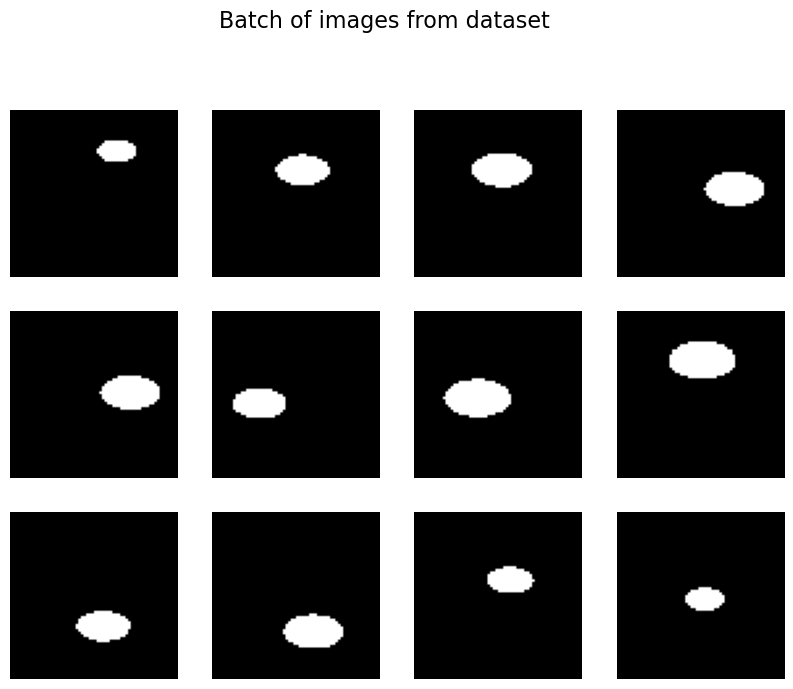

In [149]:

# importer la bibliothèque nécéssaire pour la création et l'affichage des figures (c.f paragraphe suivant)

import matplotlib.pyplot as plt

# grâce au framework pyplot de matplotlib, afficher dans une même figure les
# douze premières images du jeu de données.
# Attention, dans un premier temps il vous sera nécessaire d'importer de façon
# adéquate la bibliothèque nécéssaire.

train_batch = next(iter(train_gen))

fig = plt.figure(figsize=(10,10))
fig.suptitle('Batch of images from dataset', fontsize=16)
for i in range(12):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.squeeze(np.float32(train_batch[i])), cmap='gray')
    plt.axis('off')
plt.show()

Vérifiez que vos données soient bien mélangées, et que vous ne voyez pas deux images possédant différentes orientations et différentes formes. Voyez-vous uniquement des ovales ? Ont-ils tous bien la même orientation ? Néanmoins, sont-ils de taille et de position différentes ? Vérifions les valeurs maximales et minimales d'un batch aléatoire.

In [150]:
print(train_batch.max())
print(train_batch.min())

tensor(1.)
tensor(0.)


Les valeurs obtenues sont bien 1.0 et 0.0 ?

# II - Création du modèle #

Une fois les données récupérées, standardisées et le générateur créé, nous allons désormais créer le modèle d'auto-encodeur variationnel. Pour cela, ce dernier va être décomposé en trois classes : dans un premier temps nous allons définir l'architecture de l'encodeur basé sur des couches de convolutions, l'architecture du décodeur basé sur des couches de déconvolutions, et finalement le VAE dans sa globalité.

In [151]:
# Import des librairies nécessaires à la création du modèle d'auto-encodeur
# variationnel, avec l'aide du framework pytorch.

import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from torchvision.utils import save_image
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [152]:
# Créez les variables suivantes :
# taille d'une image : img_size
# taille du jeu de donnée d'entraînement : data_train_size
# taille du jeu de donnée de test : data_test_size
# nombre d'epochs (20) : epochs
# taille de l'espace latent (10) : latent_size

## CODE HERE
img_size = first_batch[0].shape
data_train_size = int(len(imgs)*0.7)
data_test_size = int(len(imgs)*0.3)
epochs = 30
latent_size = 10

**Création de l'architecture du modèle d'encodage**

L'encodeur spécifique à notre entraînement est constitué de quatre couches successives de convolutions suivies de trois couches denses. La première couche prend en paramètre d'entrée le batch considéré. Les deux premières couches de convolutions sont composées de trente-deux filtres de stride deux et de taille de noyeau trois. Les deux couches de convolution suivantes sont composées de soixante-quatre filtres de stride deux et de taille de noyeau trois.
La couche dense suivante est composée de 256 neurones et considère en entrée un vecteur de taille (64*4*4), et les deux couches suivantes permettent de sortir la moyenne et la log variance de la distribution de l'espace latent z, chacun faisant la taille de l'espace latent (*ici, nous considérons le logarithme néperien de la variance pour des soucis de stabilisation lors de l'apprentissage*). Pour l'ensemble des couches, mis à part les deux dernières permettant d'obtenir les paramètres de la distribution a-posteriori, la fonction d'activation ReLu est utilisée.

In [153]:
#@title
#Pour DSPRITES
# Implémenter l'architecture de l'encodeur selon les informations fournies.
# Afin de vous aider, n'oubliez pas de regarder sur internet comment cela est effectué à l'aide de Pytorch.

class Encoder(nn.Module):
   def __init__(self, latent_size):
       super(Encoder, self).__init__()
       self.latent_size = latent_size
       #CODE HERE

       self.Conv1=nn.Conv2d(1,32,kernel_size=3,stride=2, padding=1)
       self.Conv2=nn.Conv2d(32,32,3,2, padding=1)
       self.Conv3=nn.Conv2d(32,64,3,2, padding=1)
       self.Conv4=nn.Conv2d(64,64,3,2, padding=1)

       self.Flat=nn.Flatten()

       self.Dense1=nn.Linear(64*4*4,256)
       self.Mu=nn.Linear(256,latent_size)
       self.LogVar=nn.Linear(256,latent_size)

   def forward(self, x):

      #CODE HERE

     conv1=F.relu(self.Conv1(x))
     conv2=F.relu(self.Conv2(conv1))
     conv3=F.relu(self.Conv3(conv2))
     conv4=F.relu(self.Conv4(conv3))
     flat=self.Flat(conv4)
     dense1=F.relu(self.Dense1(flat))
     mu=self.Mu(dense1)
     log_var=self.LogVar(dense1)
     return mu,log_var

**Création de l'architecture du modèle de décodage**

Le décodeur est défini par une architecture symmétrique à celle de l'encodeur. Les couches de convolutions considérées correspondent à des déconvolutions afin d'augmenter à chaque étape la taille du paramètre d'entrée. Le modèle considère en entrée un échantillon de l'espace latent, et retourne en sortie une reconstruction du batch.

** Indice ** : Pour passer d'une couche Dense à une couche de convolution, il est nécéssaire d'appliquer une couche dite "Unflatten" qui permet de modifier la shape d'une couche de neurones dense.

In [154]:
#@title
# Pour DSPRITES
# Implémenter l'architecture du décodeur selon les informations fournies.
# Afin de vous aider, n'oubliez pas de regarder sur internet comment cela est effectué.

class Decoder(nn.Module):
   def __init__(self, latent_size):
       super(Decoder, self).__init__()

        #CODE HERE
       self.DenseInv=nn.Linear(latent_size,256)
       self.Dense2=nn.Linear(256,64*4*4)
       self.UnFlatten=nn.Unflatten(dim=1,unflattened_size=(64,4,4))
       self.InvConv1=nn.ConvTranspose2d(64,64,2,2)
       self.InvConv2=nn.ConvTranspose2d(64,64,2,2)
       self.InvConv3=nn.ConvTranspose2d(64,32,2,2)
       self.InvConv4=nn.ConvTranspose2d(32,1,2,2)

   def forward(self, z):

       # CODE HERE
       dense1=F.relu(self.DenseInv(z))
       dense2=F.relu(self.Dense2(dense1))
       unflat = self.UnFlatten(dense2)
       invconv1=F.relu(self.InvConv1(unflat))
       invconv2=F.relu(self.InvConv2(invconv1))
       invconv3=F.relu(self.InvConv3(invconv2))
       sortie= torch.sigmoid(self.InvConv4(invconv3))
       return sortie

**Création du modèle de VAE**


Une fois l'encodeur et le décodeur implémentés, nous allons les réunir dans une même classe permettant la bonne rétropropagation des gradients. Pour cela, la classe VAE prend en paramètres d'instance l'encodeur, le décodeur et la taille définie pour l'espace latent (*i.e. la variable "latent_size"* ).
La méthode reparametrize() permet d'appliquer l'astuce de reparamétrisation afin de permettre la rétropropation du gradient (*c.f. cours sur les modèles génératifs*), et la méthode forward() prend en donnée le batch considéré et retourne l'image reconstruite ainsi que les paramètres de moyenne et de log_variance de l'espace latent.

***Attention*** : Nous travaillons désormais avec le log de la variance de (z). Il faut donc le prendre en considération dans la technique de reparamétrisation.

In [155]:
from numpy.ma.core import log
class VAE(nn.Module):
  """
  """
  def __init__(self, latent_size, encoder, decoder):
    super(VAE, self).__init__()
    self.latent_size = latent_size
    self.encoder = encoder
    self.decoder = decoder

  def reparam(self, mu, logvar):
    epsilon = torch.normal(0,1, size=mu.shape).to(device) 
    z = mu + torch.exp(0.5 * logvar) * epsilon
    return z

  def forward(self, x):
    mu, log_var = self.encoder(x)
    z = self.reparam(mu, log_var)
    reconstructed_img = self.decoder(z)
    return reconstructed_img, mu, log_var

# III - Création de la classe d'apprentissage #

La dernière étape avant de lancer l'entraînement du modèle, consiste à implémenter le calcul de la fonction de perte du modèle et d'appliquer l'algorithme de descente de gradient pour la mise à jour des paramètres. Pour cela, la classe Training doit contenir l'ensemble des méthodes permettant de calculer les différents termes de l'ELBO, ainsi qu'une méthode step() qui consiste à mettre à jour les paramètres pour chaque batch. De plus, il faudra également implémenter la méthode train() afin de lancer le processus d'apprentissage sur un nombre d'epochs données.

Pour la méthode step(), deux cas sont à considérer :


1.   Lorsque l'on souhaite entraîner le jeu de données sur le jeu d'apprentissage, nous allons venir calculer la fonction de coût et appliquer la mise à jour des gradients en fonction de la valeur de cette dernière moyennée sur les données du batch.
2.   Lorsque l'on souhaite tester le réseau sur le jeu de données de test, nous souhaitons calculer la valeur de la fonction de coût sans effectuer de rétropropagation. De plus, on souhaite sauvegarder toutes les cinq epochs une figure composée des images reconstruites pour un batch, grâce à la fonction plot_save_img().

In [156]:
class Training():
    def __init__(self, model, optimizer):

        #CODE HERE
        self.model = model
        self.optimizer = optimizer

    def gaussian_kl(self, mu, logvar):
        #CODE HERE
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), axis=-1)
        return torch.mean(kl)

    def log_prob(self, batch, decoded_img, sigma=0.02):
        #CODE HERE
        # sigma est fixé à = 0.02
        log_unnormalized = -0.5 * ((decoded_img / sigma) - (batch / sigma))**2
        log_normalization = 0.5 * np.log(2. * np.pi) + np.log(sigma)
        log_prob = torch.mean(torch.sum(torch.squeeze((log_unnormalized- log_normalization)), [-1, -2]))
        return -1*log_prob

    def cost_function(self, log_prob, kl):
      #CODE HERE
      return log_prob + kl

    def plot_save_img(self, reconstructed_img, epoch):
        #CODE HERE
        save_image(reconstructed_img.cpu(), 'reconstructed_img_{}.png'.format(epoch))

    def fit(self, model, dataloader):
        model.train()
        for i, data in tqdm(enumerate(dataloader), total=int(data_train_size/dataloader.batch_size)):
          data = data.to(device)
          self.optimizer.zero_grad()
          reconstructed, mu, logvar = self.model(data)
          divergence = self.gaussian_kl(mu, logvar)
          recons = self.log_prob(data, reconstructed)
          elbo = self.cost_function(recons, divergence)
          elbo.backward()
          self.optimizer.step()

    def validate(self, model, dataloader, epoch):
      model.eval()
      running_loss = []
      kl_loss = []
      log_prob = []
      with torch.no_grad():
          for i, data in tqdm(enumerate(dataloader), total=int(data_test_size/dataloader.batch_size)):
              data = data.to(device)
              reconstructed, mu, logvar = self.model(data)
              divergence = self.gaussian_kl(mu, logvar)
              recons = self.log_prob(data, reconstructed)
              elbo = self.cost_function(recons, divergence)
              running_loss.append(elbo)
              kl_loss.append(divergence)
              log_prob.append(recons)
              self.plot_save_img(reconstructed, epoch)
      loss = torch.mean(torch.tensor(running_loss)).cpu().item()
      kl = torch.mean(torch.tensor(kl_loss)).cpu().item()
      log_prob = torch.mean(torch.tensor(log_prob)).cpu().item()
      return loss, kl, log_prob

    def train(self, epochs, beta):
      loss = []
      kl = []
      recons = []
      for epoch in range(epochs):
        self.fit(self.model, train_gen)
        loss_test, kl_test, log_prob_test  = self.validate(self.model, test_gen, epoch)
        loss.append(loss_test)
        kl.append(kl_test)
        recons.append(log_prob_test)
        template = 'Epoch {}, kl : {},  rec : {}, elbo : {} '
        print(template.format(
                    epoch,
                    kl_test,
                    log_prob_test,
                    loss_test))

      return loss, kl, recons

# IV - Lancement de l'apprentissage #

Passons désormais à l'étape d'apprentissage! Il nous suffit de créer une instance du modèle, et de la classe d'entraînement, et d'appeler la fonction "train". Le plus gros par la suite est... d'attendre !

**Instantiation du modèle**



In [157]:
# Créer une variable "lr" qui correspond à la taille de la "learning rate"
# appliquée par l'algorithme d'optimisation lors du processus d'apprentissage.
# Cette dernière sera définie à 1e-3.
lr = 1e-3
# Créer également une variable "beta", qui correspond au terme de
# ponderation qui sera appliqué au terme de KL-divergence de l'ELBO.
# Dans un premier temps, nous allons la définir à 1.

# CODE HERE
beta=1

# Créer une instance du modèle
# Attention, il manque les paramètres d'instance.
latent_size = 10
encoder = Encoder(latent_size)
decoder = Decoder(latent_size)
model = VAE(latent_size, encoder, decoder).to(device)

# Créer une instance de l'algorithme de descente de gradient appliqué pour
# la mise à jour des poids

optimizer = optim.Adam(model.parameters(), lr=lr)

# Créer une instance de la classe d'entraînement

#CODE HERE
training = Training(model, optimizer)

**Visualisation de l'architecture**

Une fois nos instances créées, il est possible de visualiser l'architecture définie pour l'encodeur et le décodeur grâce à la fonction summary() de la librairie torchsummary.

In [158]:
# Importer la librairie nécéssaire
from torchsummary import summary
#CODE HERE

# Visualiser l'architecture de l'encodeur grâce à la méthode summary() de la
# librairie "torchsummary"

#CODE HERE
print(summary(model.encoder, (1, 64, 64)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          320
├─Conv2d: 1-2                            [-1, 32, 16, 16]          9,248
├─Conv2d: 1-3                            [-1, 64, 8, 8]            18,496
├─Conv2d: 1-4                            [-1, 64, 4, 4]            36,928
├─Flatten: 1-5                           [-1, 1024]                --
├─Linear: 1-6                            [-1, 256]                 262,400
├─Linear: 1-7                            [-1, 10]                  2,570
├─Linear: 1-8                            [-1, 10]                  2,570
Total params: 332,532
Trainable params: 332,532
Non-trainable params: 0
Total mult-adds (M): 4.69
Input size (MB): 0.02
Forward/backward pass size (MB): 0.35
Params size (MB): 1.27
Estimated Total Size (MB): 1.64
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 

In [159]:
# Visualiser l'architecture du décodeur grâce à la méthode summary() de la
# librairie "torchsummary"

print(summary(model.decoder, (10, )))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 2,816
├─Linear: 1-2                            [-1, 1024]                263,168
├─Unflatten: 1-3                         [-1, 64, 4, 4]            --
├─ConvTranspose2d: 1-4                   [-1, 64, 8, 8]            16,448
├─ConvTranspose2d: 1-5                   [-1, 64, 16, 16]          16,448
├─ConvTranspose2d: 1-6                   [-1, 32, 32, 32]          8,224
├─ConvTranspose2d: 1-7                   [-1, 1, 64, 64]           129
Total params: 307,233
Trainable params: 307,233
Non-trainable params: 0
Total mult-adds (M): 14.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 1.17
Estimated Total Size (MB): 1.62
Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 256]                 2,816
├─Linear: 1-2                            [-1, 1024]  

**Lancement de l'apprentissage**

Appelons désormais la méthode qui lance l'apprentissage. N'oubliez pas de regarder les images que vous générez lors de la boucle sur les données de test.
Si tout va bien, vous devriez une convergence dans la reconstruction des données des les premières epochs.

In [160]:
# Lancer l'apprentissage du réseau, selon le nombre d'epochs définies

#CODE HERE
loss, kl, recons = training.train(epochs, beta)

34it [00:00, 52.84it/s]                        
15it [00:00, 24.33it/s]                        


Epoch 0, kl : 453.1192626953125,  rec : 198607.21875, elbo : 199060.34375 


34it [00:00, 86.60it/s]                        
15it [00:00, 16.25it/s]                        


Epoch 1, kl : 93.02536010742188,  rec : 184829.796875, elbo : 184922.8125 


34it [00:00, 87.87it/s]                        
15it [00:01, 14.60it/s]                        


Epoch 2, kl : 67.566650390625,  rec : 180944.546875, elbo : 181012.140625 


34it [00:00, 89.30it/s]                        
15it [00:01, 13.59it/s]                        


Epoch 3, kl : 63.164920806884766,  rec : 179658.6875, elbo : 179721.859375 


34it [00:00, 86.65it/s]                        
15it [00:01, 14.49it/s]                        


Epoch 4, kl : 70.77095031738281,  rec : 179230.921875, elbo : 179301.6875 


34it [00:00, 86.15it/s]                        
15it [00:01, 14.25it/s]                        


Epoch 5, kl : 76.98513793945312,  rec : 177895.5, elbo : 177972.484375 


34it [00:00, 86.32it/s]                        
15it [00:01, 14.26it/s]                        


Epoch 6, kl : 82.9957504272461,  rec : 177095.109375, elbo : 177178.078125 


34it [00:00, 89.52it/s]                        
15it [00:01, 14.05it/s]                        


Epoch 7, kl : 76.44586944580078,  rec : 175890.59375, elbo : 175967.078125 


34it [00:00, 89.11it/s]                        
15it [00:00, 15.50it/s]                        


Epoch 8, kl : 87.73554992675781,  rec : 160968.8125, elbo : 161056.53125 


34it [00:00, 85.34it/s]                        
15it [00:00, 24.97it/s]                        


Epoch 9, kl : 369.8931884765625,  rec : 103234.1953125, elbo : 103604.078125 


34it [00:00, 88.47it/s]                        
15it [00:00, 32.35it/s]                        


Epoch 10, kl : 1080.9927978515625,  rec : 57011.86328125, elbo : 58092.8515625 


34it [00:00, 84.36it/s]                        
15it [00:00, 36.00it/s]                        


Epoch 11, kl : 1877.7987060546875,  rec : 17846.341796875, elbo : 19724.142578125 


34it [00:00, 84.96it/s]                        
15it [00:00, 36.08it/s]                        


Epoch 12, kl : 1703.4083251953125,  rec : 11761.26953125, elbo : 13464.6787109375 


34it [00:00, 88.46it/s]                        
15it [00:00, 37.53it/s]                        


Epoch 13, kl : 1640.3179931640625,  rec : 8343.818359375, elbo : 9984.1357421875 


34it [00:00, 85.12it/s]                        
15it [00:00, 38.88it/s]                        


Epoch 14, kl : 1483.0028076171875,  rec : 7968.7109375, elbo : 9451.7138671875 


34it [00:00, 89.10it/s]                        
15it [00:00, 37.27it/s]                        


Epoch 15, kl : 1420.5941162109375,  rec : 6351.9912109375, elbo : 7772.5859375 


34it [00:00, 85.52it/s]                        
15it [00:00, 38.94it/s]                        


Epoch 16, kl : 1370.9559326171875,  rec : 5692.744140625, elbo : 7063.7001953125 


34it [00:00, 87.67it/s]                        
15it [00:00, 36.46it/s]                        


Epoch 17, kl : 1239.872802734375,  rec : 4936.4794921875, elbo : 6176.35205078125 


34it [00:00, 84.99it/s]                        
15it [00:00, 38.75it/s]                        


Epoch 18, kl : 1191.6046142578125,  rec : 4710.337890625, elbo : 5901.94287109375 


34it [00:00, 86.18it/s]                        
15it [00:00, 38.76it/s]                        


Epoch 19, kl : 1174.7420654296875,  rec : 4452.7236328125, elbo : 5627.46630859375 


34it [00:00, 86.05it/s]                        
15it [00:00, 37.31it/s]                        


Epoch 20, kl : 1100.31103515625,  rec : 4738.34716796875, elbo : 5838.65869140625 


34it [00:00, 85.63it/s]                        
15it [00:00, 39.00it/s]                        


Epoch 21, kl : 1100.852294921875,  rec : 3755.515625, elbo : 4856.3681640625 


34it [00:00, 85.22it/s]                        
15it [00:00, 37.41it/s]                        


Epoch 22, kl : 1046.0260009765625,  rec : 3297.79296875, elbo : 4343.8193359375 


34it [00:00, 86.41it/s]                        
15it [00:00, 38.99it/s]                        


Epoch 23, kl : 911.1175537109375,  rec : 5571.47607421875, elbo : 6482.59326171875 


34it [00:00, 85.74it/s]                        
15it [00:00, 38.68it/s]                        


Epoch 24, kl : 923.4022827148438,  rec : 3107.397216796875, elbo : 4030.7998046875 


34it [00:00, 89.69it/s]                        
15it [00:00, 38.31it/s]                        


Epoch 25, kl : 933.9799194335938,  rec : 4461.7470703125, elbo : 5395.72705078125 


34it [00:00, 87.05it/s]                        
15it [00:00, 38.92it/s]                        


Epoch 26, kl : 917.7914428710938,  rec : 3815.40625, elbo : 4733.19775390625 


34it [00:00, 84.83it/s]                        
15it [00:00, 37.66it/s]                        


Epoch 27, kl : 810.6704711914062,  rec : 5152.68115234375, elbo : 5963.3515625 


34it [00:00, 89.36it/s]                        
15it [00:00, 38.96it/s]                        


Epoch 28, kl : 830.6039428710938,  rec : 3960.4794921875, elbo : 4791.08349609375 


34it [00:00, 88.58it/s]                        
15it [00:00, 36.27it/s]                        

Epoch 29, kl : 833.2593383789062,  rec : 2715.97314453125, elbo : 3549.23291015625 


# Visualisation des résultats #

Pour terminer ce TD, nous allons regarder comment s'est déroulé notre apprentissage. Une première étape consiste à regarder la convergence de la fonction coût. Il est intéréssant également de considérer chacun des termes de façon distinctes. \\
Pour terminer, nous allons regarder les informations encodées dans chacune des dimension de l'espace latent de façon indépendante, à travers un "latent traversal".

**Visualisation de la convergence de la fonction coût**

Implémenter la fonction "loss_visualisation()" qui prend en entrée des tableaux
numpy comportant les valeurs considérées pour chaque batch de l'entraînement.
Cette fonction permet la création et l'affichage d'une seule figure, sur laquelle trois sous-figures représentent chacune l'évolution de la fonction coût, ou l'évolution de la KL-divergence ou enfin l'évolution de la valeur de reconstruction par batch durant l'apprentissage.


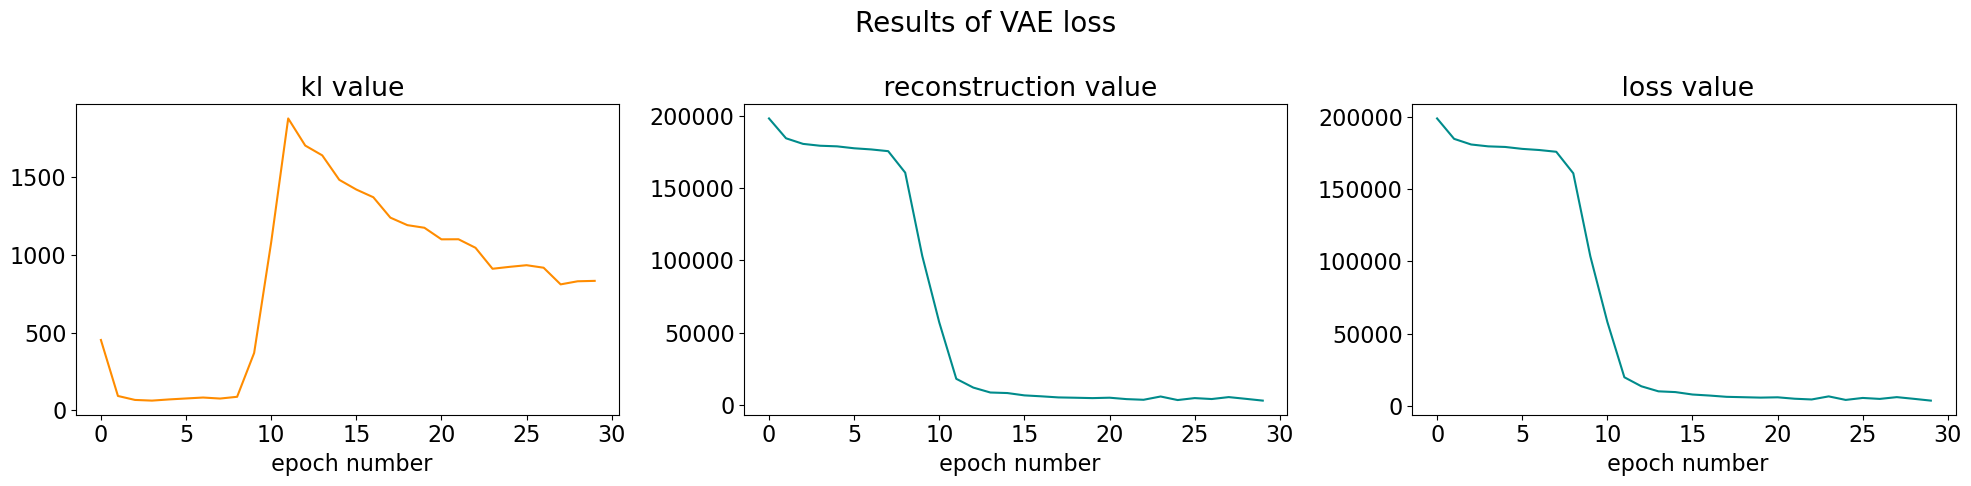

In [161]:
# Imlpémenter une fonction et qui permet la visualisation de la convergence

#CODE HERE

plt.rcParams['figure.figsize' ] = (20,5)
plt.rcParams['figure.autolayout' ] = True
plt.rcParams['font.size'] = '16'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Results of VAE loss', size=20)

ax1.plot(kl, color='darkorange')
ax1.set_title(' kl value' )
ax1.set_xlabel(' epoch number' )

ax2.plot(recons, color='darkcyan')
ax2.set_title(' reconstruction value' )
ax2.set_xlabel(' epoch number' )

ax3.plot(loss, color='darkcyan')
ax3.set_title(' loss value' )
ax3.set_xlabel(' epoch number' )

plt.savefig(' kl_recon.png' )



Vérifiez bien que vous obtenez une bonne convergence pour la fonction coût. En comparant la valeur de chacun de ses termes, que remarquez vous ? Quelle conclusion pouvez-vous en faire?

# AJOUTER VISUALISATION GENERATION ET VISIUALISATION RECONSTRUCTION

**Visualisation de la capacité de désentrelacement du modèle**

Implémenter une fonction "latent_traversal()". Cette dernière prend en paramètre d'entrée une image, ainsi que le modèle entraîné. Elle doit être capable de  créer une figure, dans laquelle on va retrouver l'impact de la modification  de la valeur de la moyenne inferrée pour chaque dimension, en allant de -2 à +2. Concernant cette méthode, réfléchisser bien à chacune des étapes nécéssaire à la visualisation, et la rééelle signification de la métrique.

In [162]:
# Implémenter la fonction latent_traversal()

def latent_traversal(model, image, latent_size):
    learned_mean, learned_var = model.encoder(image)
    gen_img_list = np.empty((0,7,1, image.shape[0],image.shape[-1], image.shape[-1]))
    for i in range(latent_size):
      generated_img = np.empty((0,1,image.shape[0], image.shape[-1], image.shape[-1]))
      learned_mean_init = learned_mean.detach().numpy()[0][i]
      for j in np.linspace(-10, 10,7):
          learned_mean.detach().numpy()[0][i] = learned_mean_init + j
          z_rep = model.reparam(learned_mean, learned_var)
          img_mean = model.decoder(z_rep).detach().numpy()
          generated_img = np.append(generated_img, [img_mean], axis=0)
      gen_img_list = np.append(gen_img_list, [generated_img], axis=0)

    fig, axs = plt.subplots(nrows=7, ncols=10)
    fig_size = plt.gcf().get_size_inches() # Get current size
    sizefactor =2 # Set a zoom factor
    # Modify the current size by the factor
    plt.gcf().set_size_inches(sizefactor * fig_size)
    fig.suptitle('Visualisation of latent space', fontsize=25)
    axs[2,0].set_ylabel('-3 --------------------- mean latent traversal ----------------- +3', fontsize=15)
    for i in range(latent_size):
        for j in range(7):
            axs[0,i].set_title("lat : " + str(i), fontsize=15)
            axs[j,i].imshow(gen_img_list[i,j,0,0,:,:],  cmap='gray')
            plt.setp(axs[j,i].get_xticklabels(), visible=False)
            plt.setp(axs[j,i].get_yticklabels(), visible=False)
            axs[j,i].tick_params(axis='both', which='both', length=0)
    plt.show()


In [163]:
# Lancer un latent traversal afin de visualiser la capacité de désentrelacement
# de votre modèle

#CODE HERE
latent_traversal(model, torch.unsqueeze(first_batch[0],0), latent_size)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

Que vous pouvez-vous conclure de la capacité de désentrelacement de votre modèle grâce à l'interprétation du latent traversal ? D'après-vous, qu'est-ce qui pourrait être amélioré ?

# Pour aller plus loin... #

De nombreux articles ont pour objetcif d'améliorer la capacité d'un VAE à produire un espace latent démêlé. Pour cette partie du TD, vous devez vous referrer aux articles cités, et implémenter les différentes parties. N'hésitez pas à me solliciter si vous avez besoin d'aide.

**Beta-VAE modèle**

*   Objectif : pondérer d'avantage le terme de KL-divergence dans la fonction coût.
*   Article : https://openreview.net/forum?id=Sy2fzU9gl


In [ ]:
# Tester avec de nouvelles valeurs de beta, et voir le résultat du désentrelacement obtenu.
# Conserver l'ensemble des paramètres préalablement définis pour la création de votre modèle.
# Vous pouvez tester avec la valeur de beta "optimale" (c.f. cours), et une valeur de beta très grande.

# CODE HERE


**Beta-VAE métrique**

*   Objectif : quantifier la capacité de désentrelacement du modèle grâce à une métrique quantitative.
*   Article : https://openreview.net/forum?id=Sy2fzU9gl


In [ ]:
# Implémentez la métrique quantitative de l'article de désentrelacement de l'article précédent,
# et comparez quantitativement les différents résultats obtenus pour vos modèles.

# CODE HERE

**Spatial Broadcast Decoder modèle**

*   Objectif : ajouter un biais inhérent à la position de l'objet dans l'image afin de favoriser le désentrelacement dans l'espace latent.
*   Article : https://arxiv.org/abs/1901.07017


In [ ]:
# Basez vous sur l'article du SBD afin de modifier votre réseau de telle sorte à
# créer un "Spatial Broadcast Décodeur".
# Créez une nouvelle instance de votre modèle et lancez un nouvel apprentissage
# avant de regarder les résultats obtenus grâce au latent traversal.
# Que pouvez-vous observer ?

# CODE HERE